<a href="https://colab.research.google.com/github/peterwu19881230/CSCE633_Machine_Learning/blob/master/lecture_jupyter_notebooks/Week_6_Discussion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6 Discussion: Decision Trees and Random Forests

## Objectives

In this week's discussion, we will learn:
* Mean imputation
* Decision trees in regression
* Decision trees in classification
* Effect of pre-pruning on decision trees
* Bagging and random forests

## Preparing the Data

Before importing the data, as usual, we import _pandas_ library to simplify data manipulation.

In [0]:
import pandas as pd

In this discussion we use _Carseats_ dataset which is the data of the sales of child car seats at 400 different stores. For more information on the dataset, please look it up!

In [0]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Carseats.csv"
df = pd.read_csv('Carseats.csv')

We now print out the dataset to gain more insight in it:

In [0]:
print (df.head(5))

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


# Handling the Missing Data, not the Easiest Version Anymore!

This week, we will not remove the rows with missing values and we perform mean imputation. We perform that after train-test split. So it will no longer be done here. It will be done in the cross-validation internal loop.

In [0]:
# df.dropna(inplace=True)

For classification, we build a new label which is indicative of sales being more than 8 (high sales) or not.

In [0]:
import numpy as np
df['high_sales'] = np.where(df['Sales']>8, 'yes', 'no')

In [0]:
df.head(5)

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US high_sales  
0         17   Yes  Yes        yes  
1         10   Yes  Yes        yes  
2         12   Yes  Yes        yes  
3         14   Yes  Yes         no  
4         13   Yes   No         no

As discussed above, the _Sales_ column in the dataset will be our label for the regression problem and _high sales_ will be our label for the classification problem. All the other columns will be our features.

In [0]:
X      = df.drop (labels=['Sales', 'high_sales'], axis=1)
y_clas = df[['high_sales']]
y_regr = df[['Sales']]

We used to convert the categorical to numerical before... not anymore!

In [0]:
X_cat = X.select_dtypes(exclude=['int64', 'float64'])                                                                                                         
X_dog = X.select_dtypes(include=['int64', 'float64'])                                                                                                         
                                                                                                                                                              
X_cat = pd.get_dummies(X_cat)                                                                                                                                 
X = pd.concat([X_cat, X_dog], axis=1)

As discussed last week, changing the name of the outputs to numbers from $0$ to $k-1$ with $k$ being the number of different classes we have:

In [0]:
highsales2number_dict = {
    'no' :0,
    'yes':1
}


y_clas=y_clas.replace({"high_sales": highsales2number_dict})

## Building a Single Decision Tree Classifier

We now build a a single decision tree classifier on our whole data:

In [0]:
from sklearn.tree import DecisionTreeClassifier


dtc = DecisionTreeClassifier(criterion         = "gini",\
                             max_depth         = None,\
                             min_impurity_decrease=0.0,\
                             min_samples_split = 2)

dtc.fit(X, y_clas)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Defining a plotting function

We now define a plotting function for plotting the decision trees. It can plot up to two decision trees. 

In [0]:
from IPython.display import Image, display
from sklearn import tree
import pydotplus

#https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/

def tree_plotter(tree_1, X_cols, y_cols, tree_2=None):
    
    # Create DOT data
    dot_data_1 = tree.export_graphviz(tree_1, out_file=None, 
                                      feature_names=X_cols,  
                                      class_names=y_cols[0])
    if not tree_2 is None:
        dot_data_2 = tree.export_graphviz(tree_2, out_file=None, 
                                          feature_names=X_cols,  
                                          class_names=y_cols[0])

    # Draw graph
    graph_1 = pydotplus.graph_from_dot_data(dot_data_1)  
    if not tree_2 is None:
        graph_2 = pydotplus.graph_from_dot_data(dot_data_2)
    
    # Show graph
    if tree_2 is None:
        display(Image(graph_1.create_png()))
    else:
        display(Image(graph_1.create_png()), Image(graph_2.create_png()))

If we plot the tree we just trained, we will have:

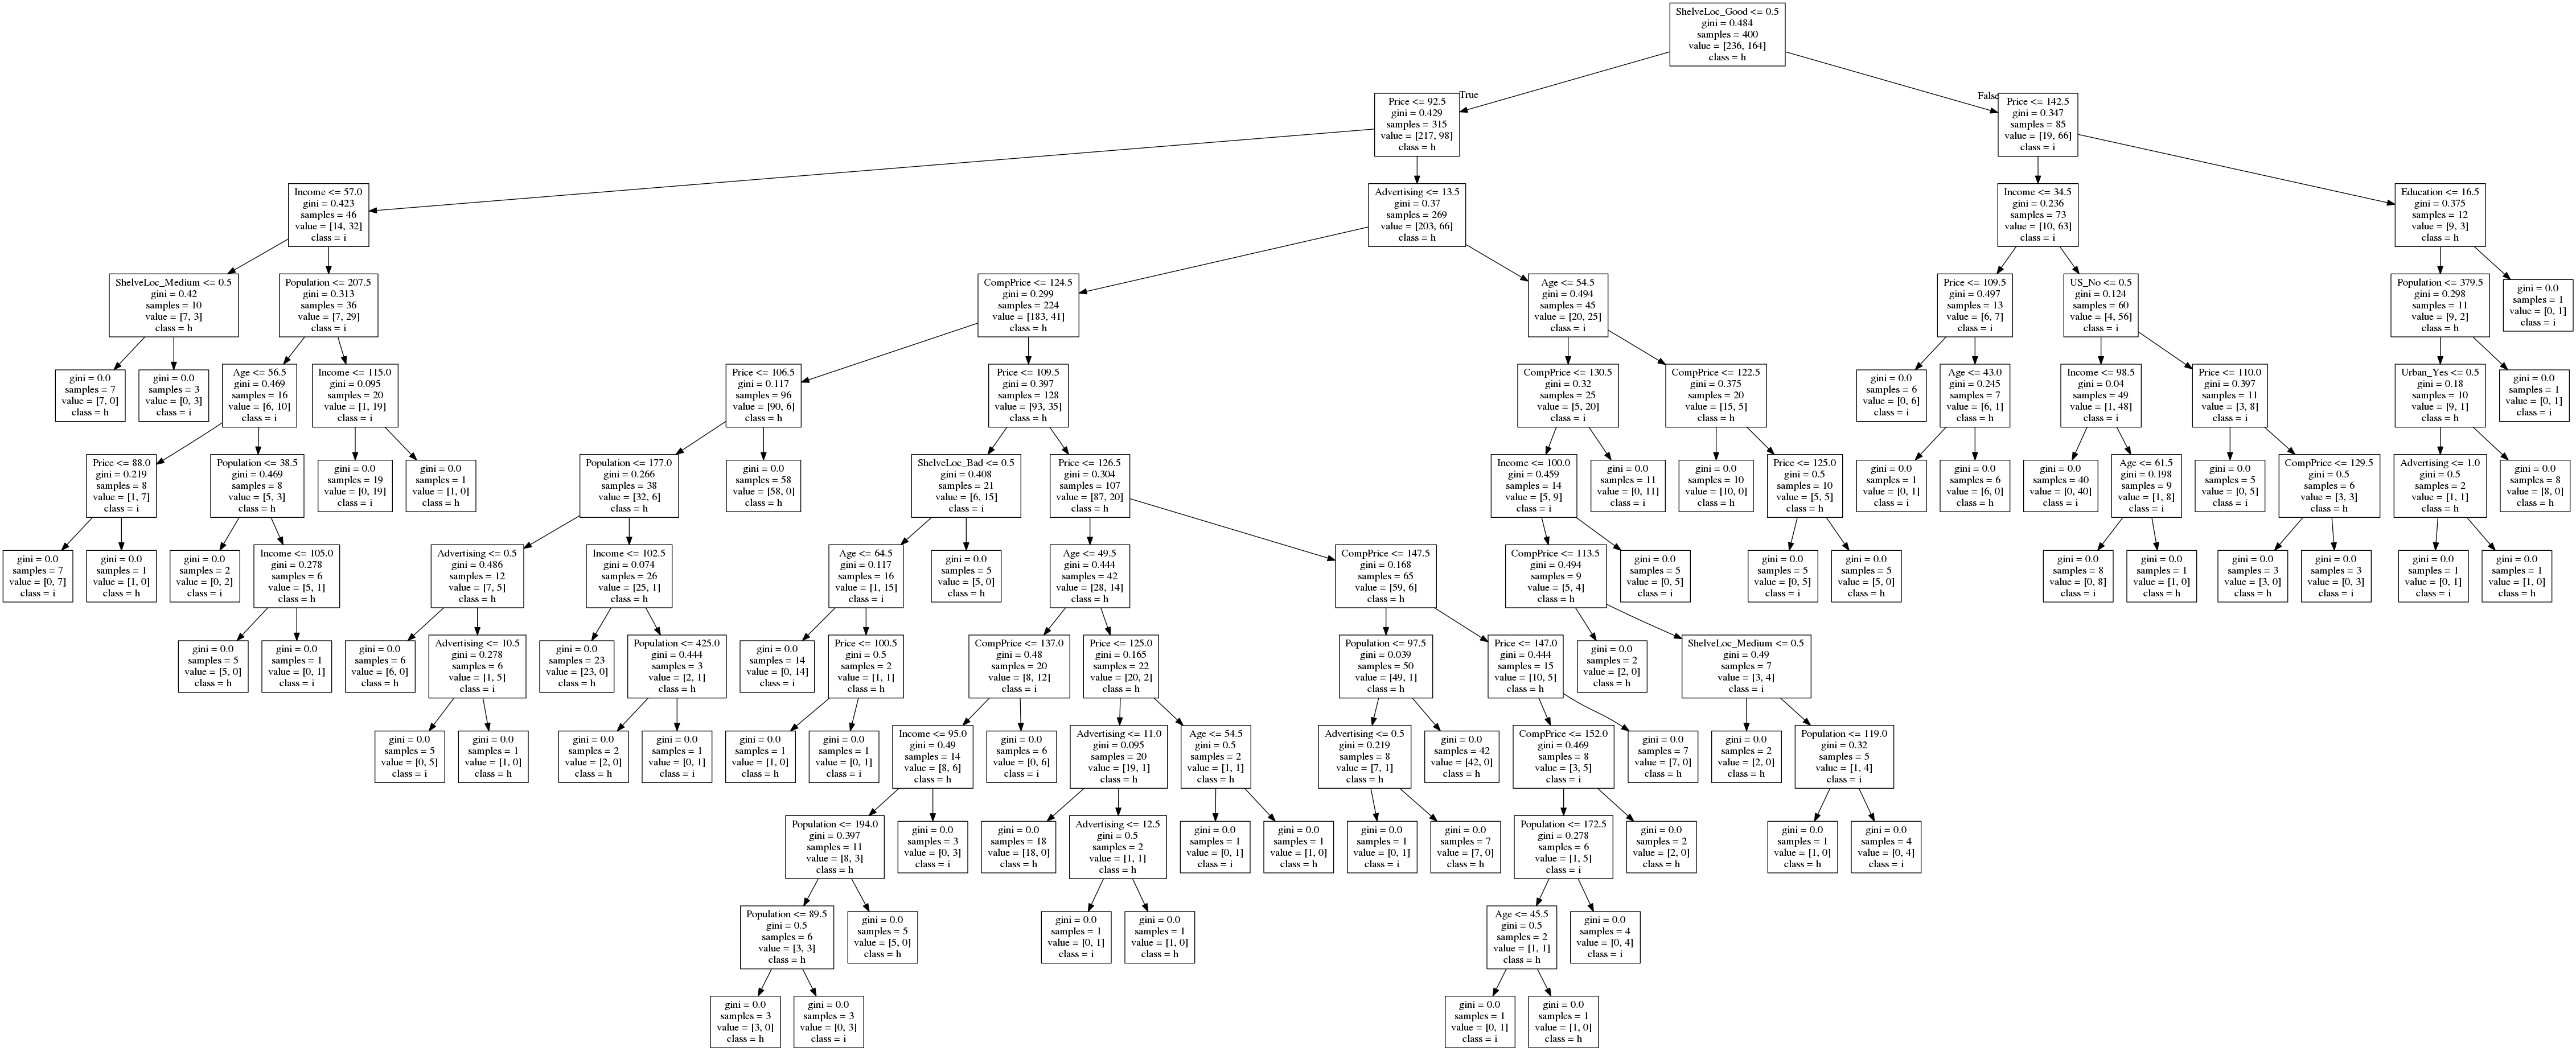

In [0]:
tree_plotter(dtc, X.columns, y_clas.columns)

## Defining a Function for Cross-validation of a Single Model

In the code snippet below a function is defined to cross validate a single model which can be any of four cases of decision tree classifier/regressor and random forest classifier/regressor. 

This week we perform mean imputation which is a better way of handling the missing data than removing rows with missing values. In order to perform that, we need to have the train-test split a priori because the mean of the training data is used for the imputation of testing data.

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import mean_squared_error

def cross_validate_single_model(model, X, y, n_folds, args):
    
    performance = 0
    
    if model.endswith("classifier"):
        splitter = StratifiedKFold(n_splits=n_folds, shuffle=True).split(X,y)
    elif model.endswith("regressor"):
        splitter =           KFold(n_splits=n_folds, shuffle=True).split(X)
        
    for train_index, test_index in splitter:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        #mean imputation
        mean_imputer = SimpleImputer()
        X_train      = mean_imputer.fit_transform(X_train)
        X_test       = mean_imputer.    transform(X_test)
        
        ##train/test
        if model   == "dt_classifier":
            model_ = DecisionTreeClassifier(**args)
            
        elif model == "dt_regressor":
            model_ = DecisionTreeRegressor (**args)
            
        elif model == "rf_classifier":
            model_ = RandomForestClassifier(**args)
            
        elif model == "rf_regressor":
            model_ = RandomForestRegressor (**args)
            
        model_.fit(X_train, y_train)
        pred   = model_.predict(X_test)
        
        if  model.endswith("classifier"):
            performance_contrib = roc_auc_score(y_test, pred)/n_folds
        elif model.endswith("regressor"):
            performance_contrib = mean_squared_error(y_test, pred)/n_folds

        
        performance += performance_contrib
    
    return performance

Using the function developed above, we assess the AUC of a single classification decision tree:

In [0]:
print ("%.2f"%cross_validate_single_model("dt_classifier", X, y_clas,\
                                        10,\
                                       {"max_depth":None,\
                                        "criterion":"entropy",\
                                        "min_impurity_decrease":0.0,\
                                        "min_samples_split":2}))

0.73


## Takes long? Make It <font color='red'>Parallel</font> !

Before delving into comparisons, similar to the last week, we will set up the parallel comupation platform for cross validating different arguments.

In [0]:
from joblib import Parallel, delayed
import multiprocessing 
from itertools import product

num_processes = 20

def cross_validate_models(model, X, y, n_folds, args):
    
    for key in args.keys():
        if len(args[key])==0:
            args[key]=[1]
            
    arg_dict_vec = [dict(zip(args.keys(), values))\
                    for values in product(*args.values())]

    
    results = Parallel(n_jobs=num_processes)\
              (delayed(cross_validate_single_model)\
              (model, X, y, n_folds, arg_dict)\
              for arg_dict in arg_dict_vec)
    
    names   = [name_creator("", n_folds, arg_dict)\
              for arg_dict in arg_dict_vec]
    
    auc_dict = dict(zip(names, results))
        
    return auc_dict

## Saving Results

Similar to the previous weeks, we will save the models in the results folder. In the following piece of code, we first check if it exists, and if not, we will create it:

In [0]:
import os

rslt_addr = "./results/"
if not os.path.exists(rslt_addr):
    os.makedirs(rslt_addr)

Following the file naming convention discussed last week, we will have:

In [0]:
def name_creator(model,n_folds, args):

    name = "model_%s__n_folds_%d"%(model, n_folds)
    
    def describe_in_string(vec):
        
        if not isinstance(vec, list):
            return vec
        
        if len(vec)==0:
            return "NA"
        
        if isinstance(vec[0], str):
            return '_'.join(vec)
    
        if len(vec)==1:
            return "%d"%vec[0]
    
        return "%d_%d"%(np.min(vec), np.max(vec))
    
    for arg in sorted(args.keys()):
            name += "__%s_%s"%(arg, describe_in_string(args[arg]))
    
    return name

We see an example here:

In [0]:
import numpy as np

model      = "dt_classifier"
n_folds    = 5
max_depths = range(1,5+1)

print ('\n'*1, name_creator(model, n_folds, {"max_depths":max_depths}), '\n'*2)


 model_dt_classifier__n_folds_5__max_depths_range(1, 6) 




The function below either loads the results or computes it:

In [0]:
import pickle
import os
import numpy as np

def cross_validate_args (model, X, y, n_folds, args):
    
    rslt_dict_name = name_creator(model, n_folds, args)
    rslt_dict_addr = os.path.join(rslt_addr, rslt_dict_name)
    
    
    if os.path.isfile(rslt_dict_addr):
        with open(rslt_dict_addr,"rb") as rslt_dict_handle:
            rslt_dict = pickle.load(rslt_dict_handle)
    else:
        rslt_dict = cross_validate_models(model, X, y, n_folds, args)
        with open(rslt_dict_addr,"wb") as rslt_dict_handle:
            pickle.dump(rslt_dict, rslt_dict_handle)

    return rslt_dict

Having our framework set up, we now begin the experiments.

## Effect of Pre-pruning on Performance

For pruning trees, we explore two different options first one being setting a maximum depth for the tree and the second one being setting a minimum value for the impurity of a node to be split.

Before pre-pruning, we see the effect of different impurity metrics on tree performance.

In [0]:
n_folds    = 10
args       = {"criterion" : ["gini","entropy"]}

cross_validate_args ("dt_classifier", X, y_clas, n_folds, args)

{'model___n_folds_10__criterion_entropy': 0.7708866155157714,
 'model___n_folds_10__criterion_gini': 0.7547714194373402}

As can be seen above, gini index works better than entropy in the current dataset.

As the first method for pre-pruning, we try different maximum depths for the decision tree. Please note that gini index is the default impurity measure in the _Sklearn_ implementation so it does not need to be specified.

In [0]:
n_folds = 10
args    = {"max_depth" : [1,2,3,4,5,6,7,8,9,10]}

cross_validate_args ("dt_classifier", X, y_clas, n_folds, args)

{'model___n_folds_10__max_depth_1': 0.6612505328218244,
 'model___n_folds_10__max_depth_10': 0.7349317988064792,
 'model___n_folds_10__max_depth_2': 0.7266703964194373,
 'model___n_folds_10__max_depth_3': 0.6806186061381074,
 'model___n_folds_10__max_depth_4': 0.7430573316283036,
 'model___n_folds_10__max_depth_5': 0.7214407502131287,
 'model___n_folds_10__max_depth_6': 0.7313991901108269,
 'model___n_folds_10__max_depth_7': 0.7230738491048593,
 'model___n_folds_10__max_depth_8': 0.7324062233589087,
 'model___n_folds_10__max_depth_9': 0.73013373827792}

As seen in the results above, results begin to saturate in terms of performance. We get a better performance with maximum depth of 6 which shows that values of more than 6 will suffer from overfitting.

We now plot two trees with maximum depths of 6 and 10:

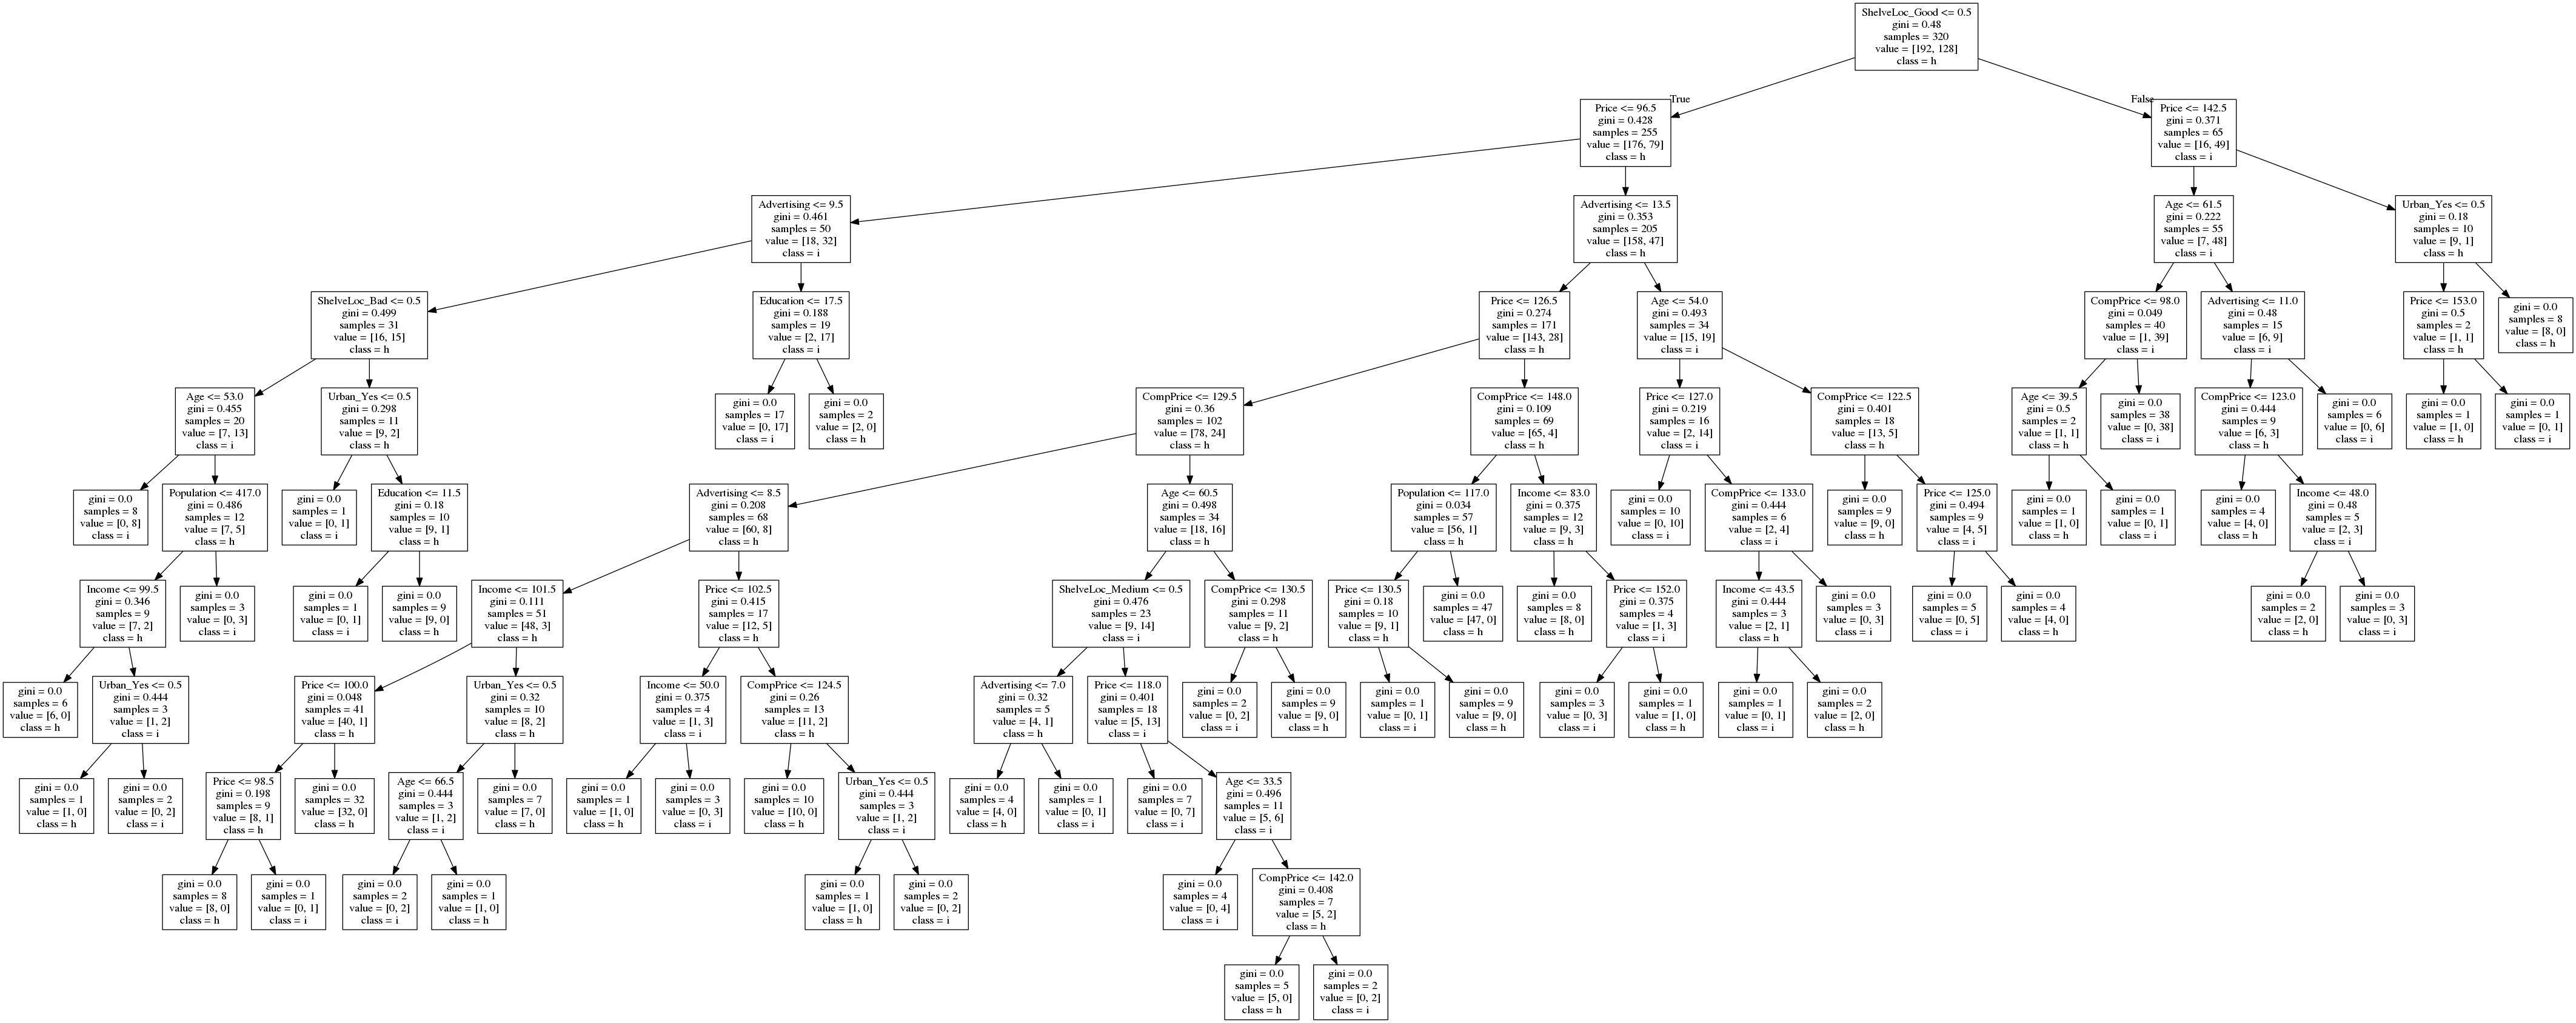

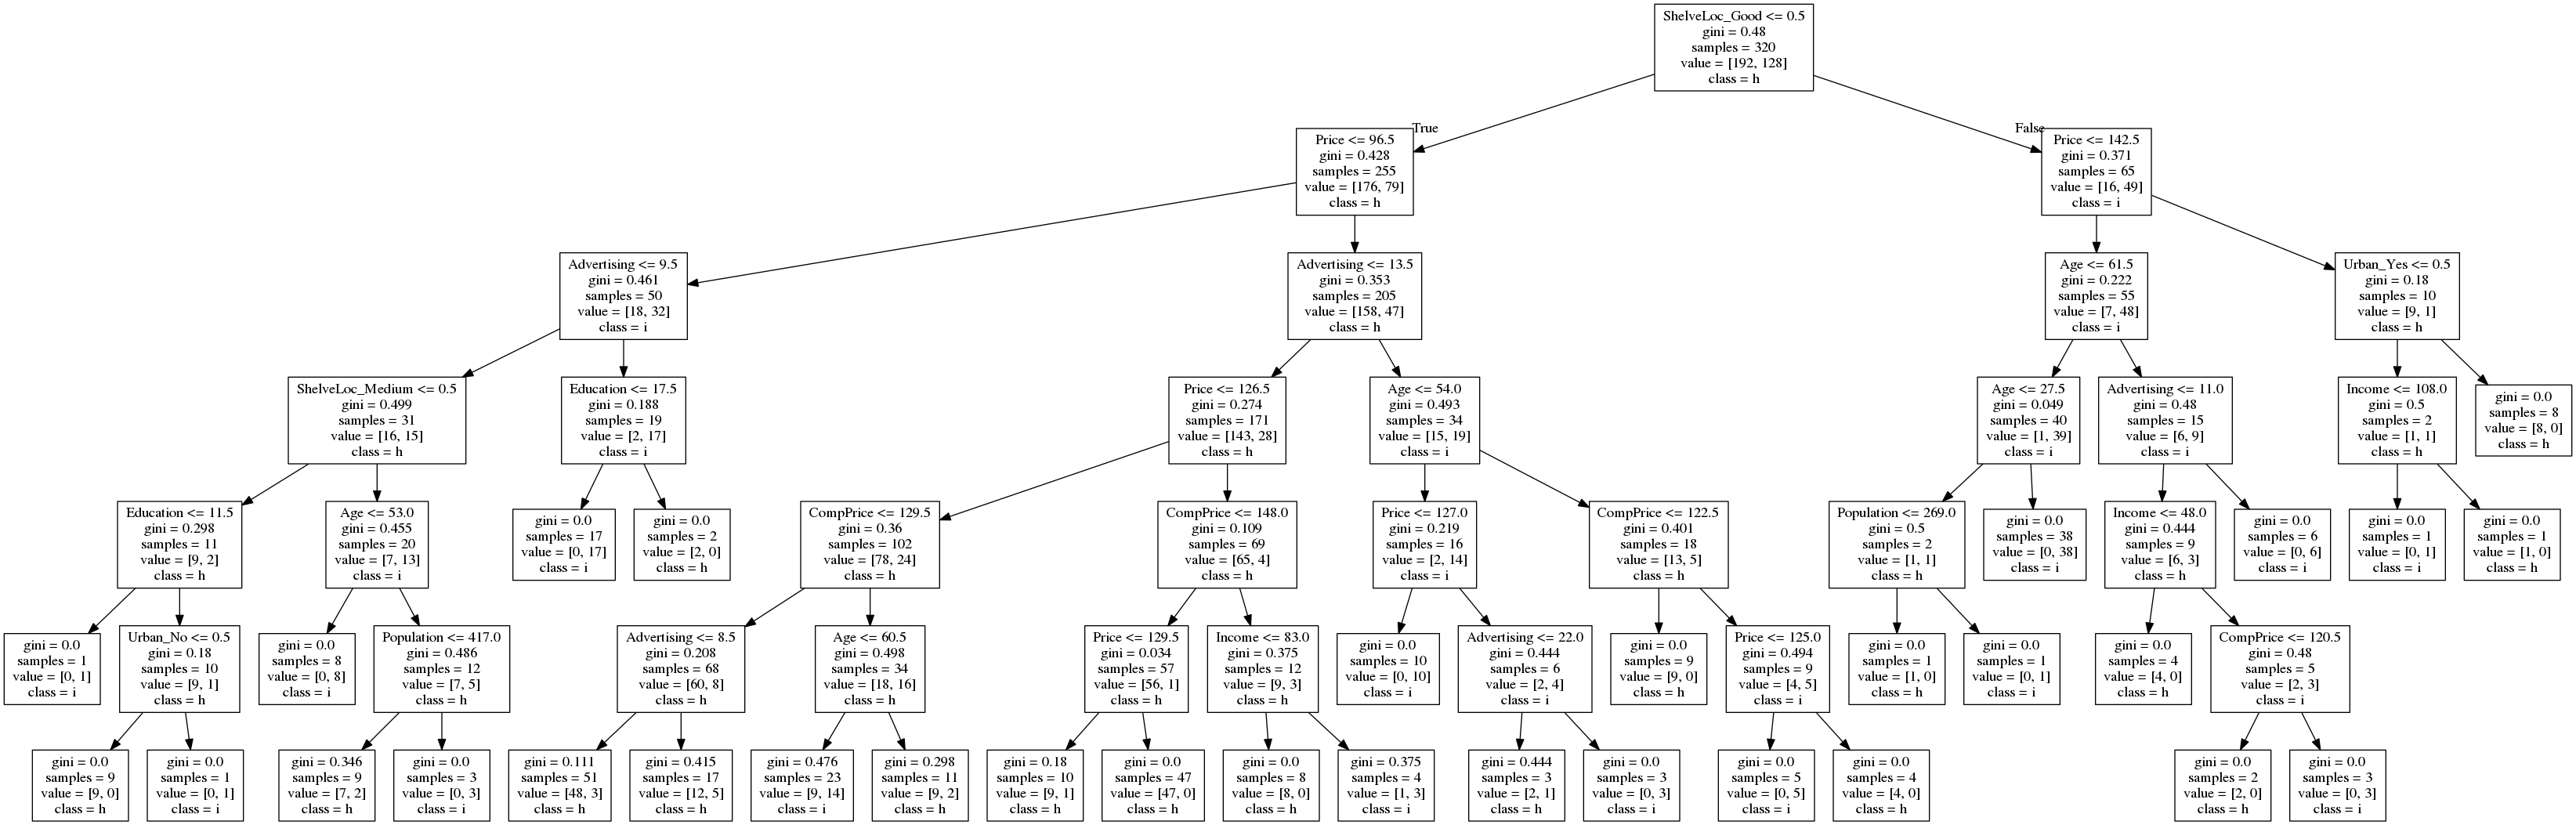

In [0]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y_clas, test_size=0.2)


dtc         = DecisionTreeClassifier(max_depth = 10)
dtc_trimmed = DecisionTreeClassifier(max_depth = 6)

dtc        .fit(X_train, y_train)
dtc_trimmed.fit(X_train, y_train)

tree_plotter(dtc, X.columns, y_clas.columns, dtc_trimmed)

Now we try diffenet minima for measuring impurity of a node to be split. If the value is equal to a number, let's say $t$, the node will not split unless the impurity is more than $t$. In the code below, the impurity is measured using gini index by default.

In [0]:
n_folds = 10

args    = {"min_impurity_split" : [0]+[x for x in np.power(float(10), range(-10, 0))]}

cross_validate_args ("dt_classifier", X, y_clas, n_folds, args)

{'model___n_folds_10__min_impurity_split_0': 0.7508232097186701,
 'model___n_folds_10__min_impurity_split_0.0001': 0.7356910699062232,
 'model___n_folds_10__min_impurity_split_0.001': 0.7275682011935208,
 'model___n_folds_10__min_impurity_split_0.01': 0.7534580136402388,
 'model___n_folds_10__min_impurity_split_0.1': 0.744661125319693,
 'model___n_folds_10__min_impurity_split_1e-05': 0.7208946078431373,
 'model___n_folds_10__min_impurity_split_1e-06': 0.7224291346973573,
 'model___n_folds_10__min_impurity_split_1e-07': 0.7384697357203751,
 'model___n_folds_10__min_impurity_split_1e-08': 0.7242940110826939,
 'model___n_folds_10__min_impurity_split_1e-09': 0.7559942455242968,
 'model___n_folds_10__min_impurity_split_1e-10': 0.7229113384484229}

As it turns out, in this dataset, pre-pruning using minimum impurity split of $0.001$, among others, reaches an AUC of 0.78 which is better than the one we have without pruning which is 0.75. Nonetheless, it can also be helpful in terms of making the model smaller. Let us plot both trees:

/home/grads/a/a.pakbin/.local/lib/python3.5/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/grads/a/a.pakbin/.local/lib/python3.5/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


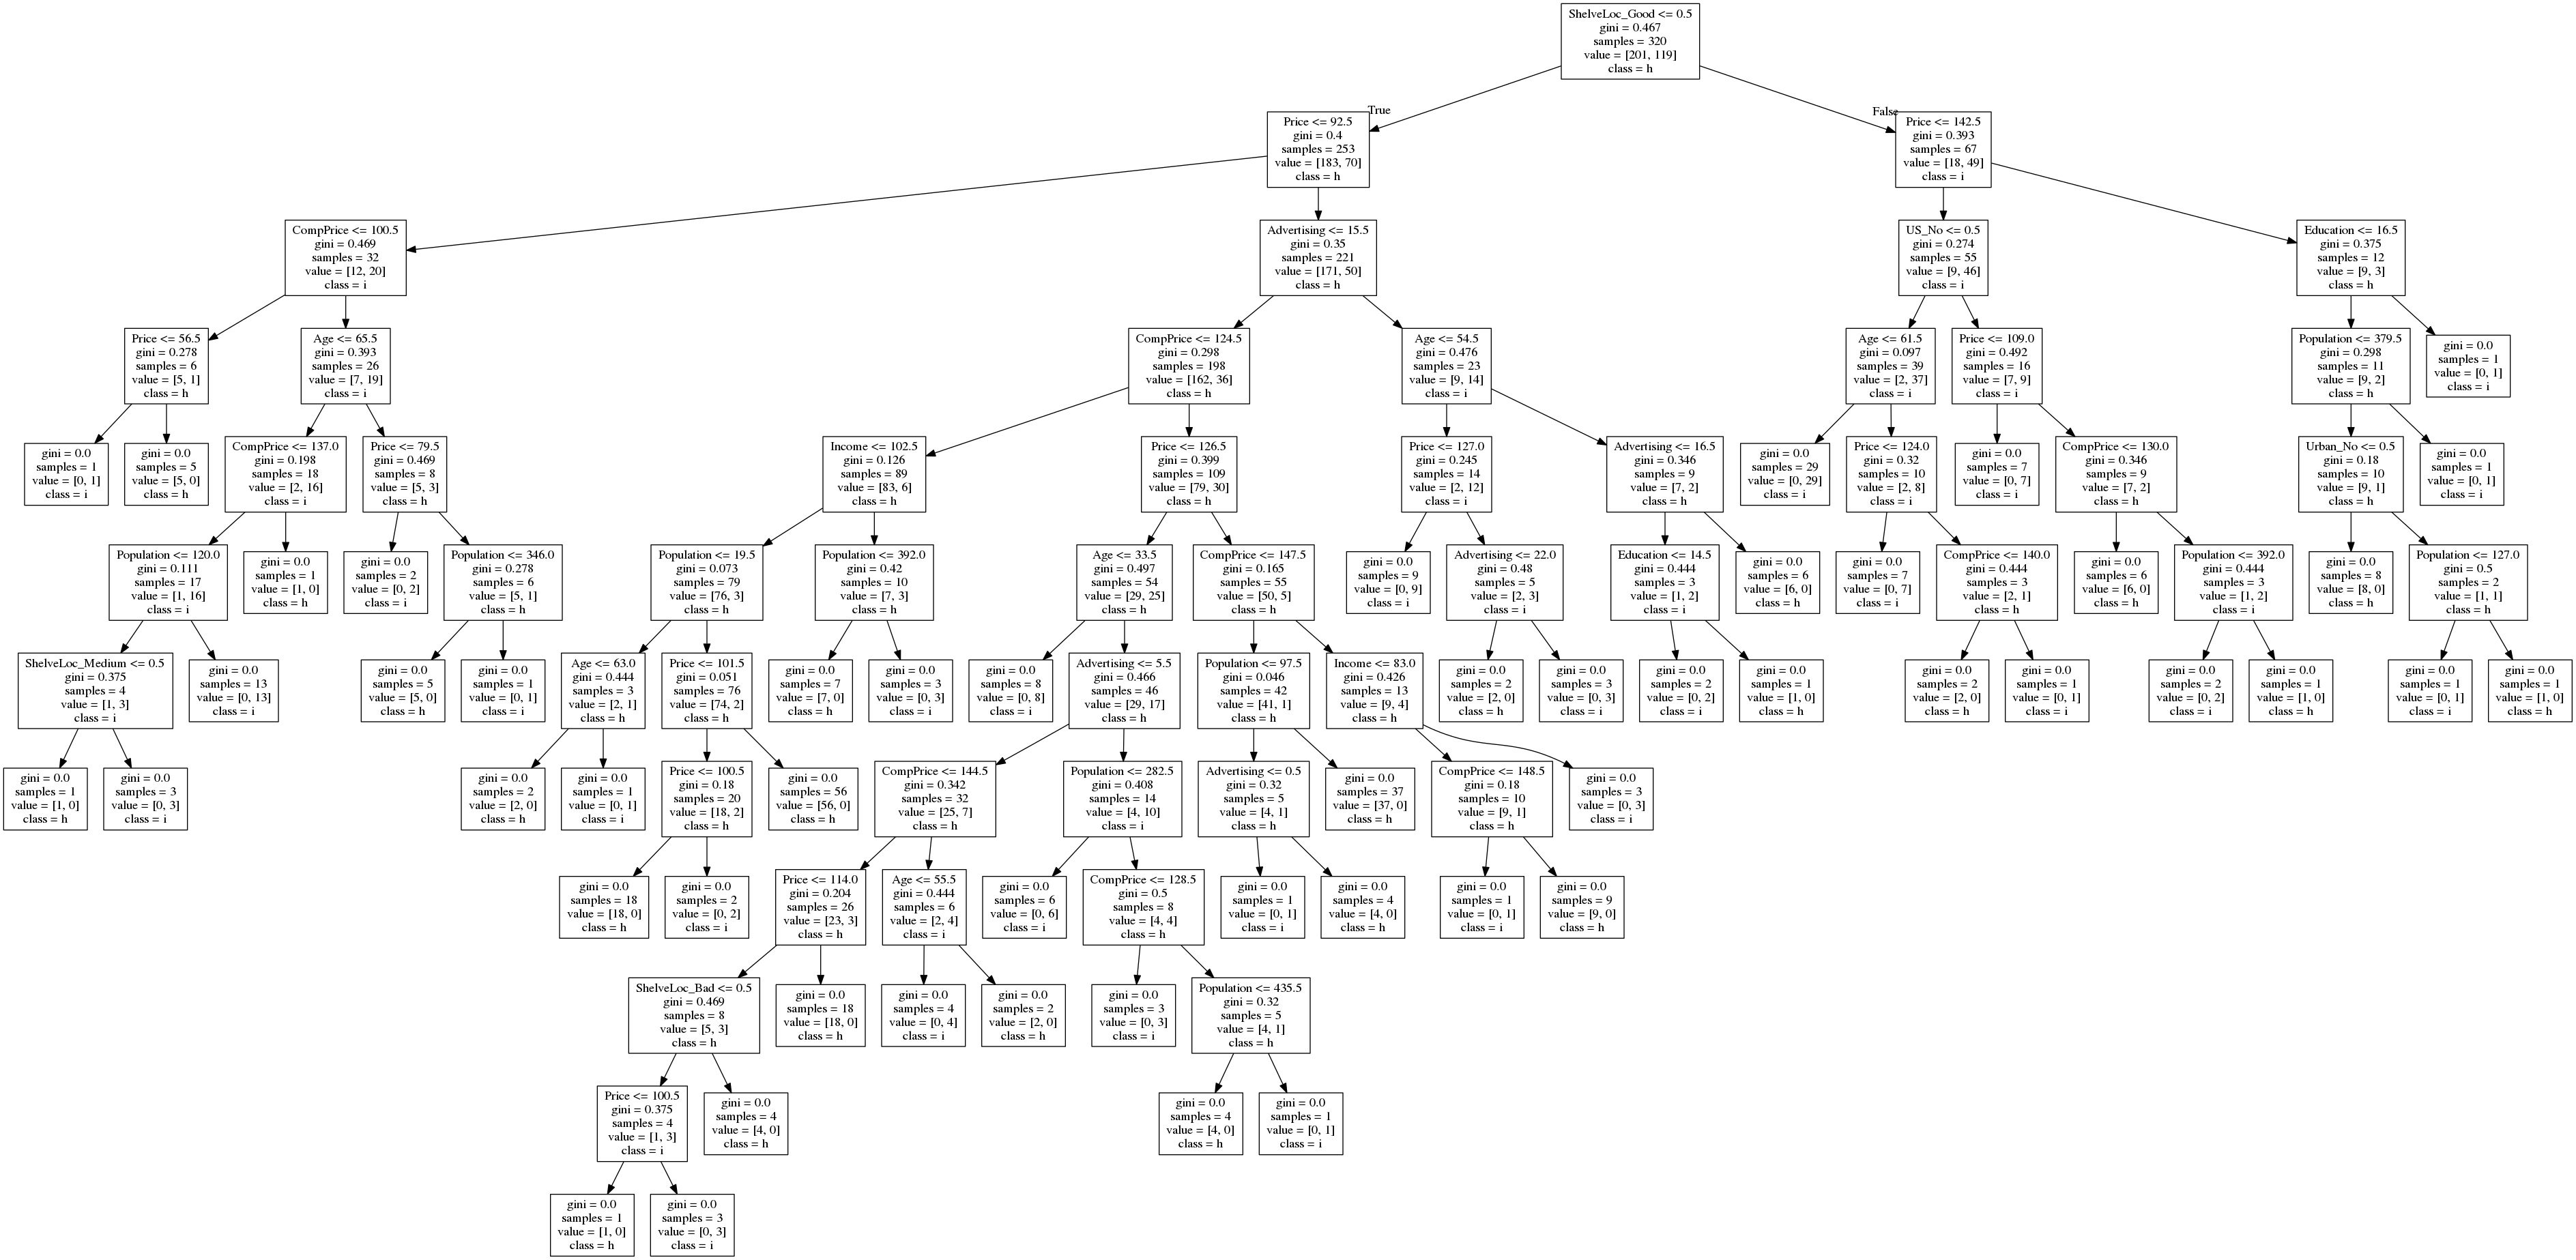

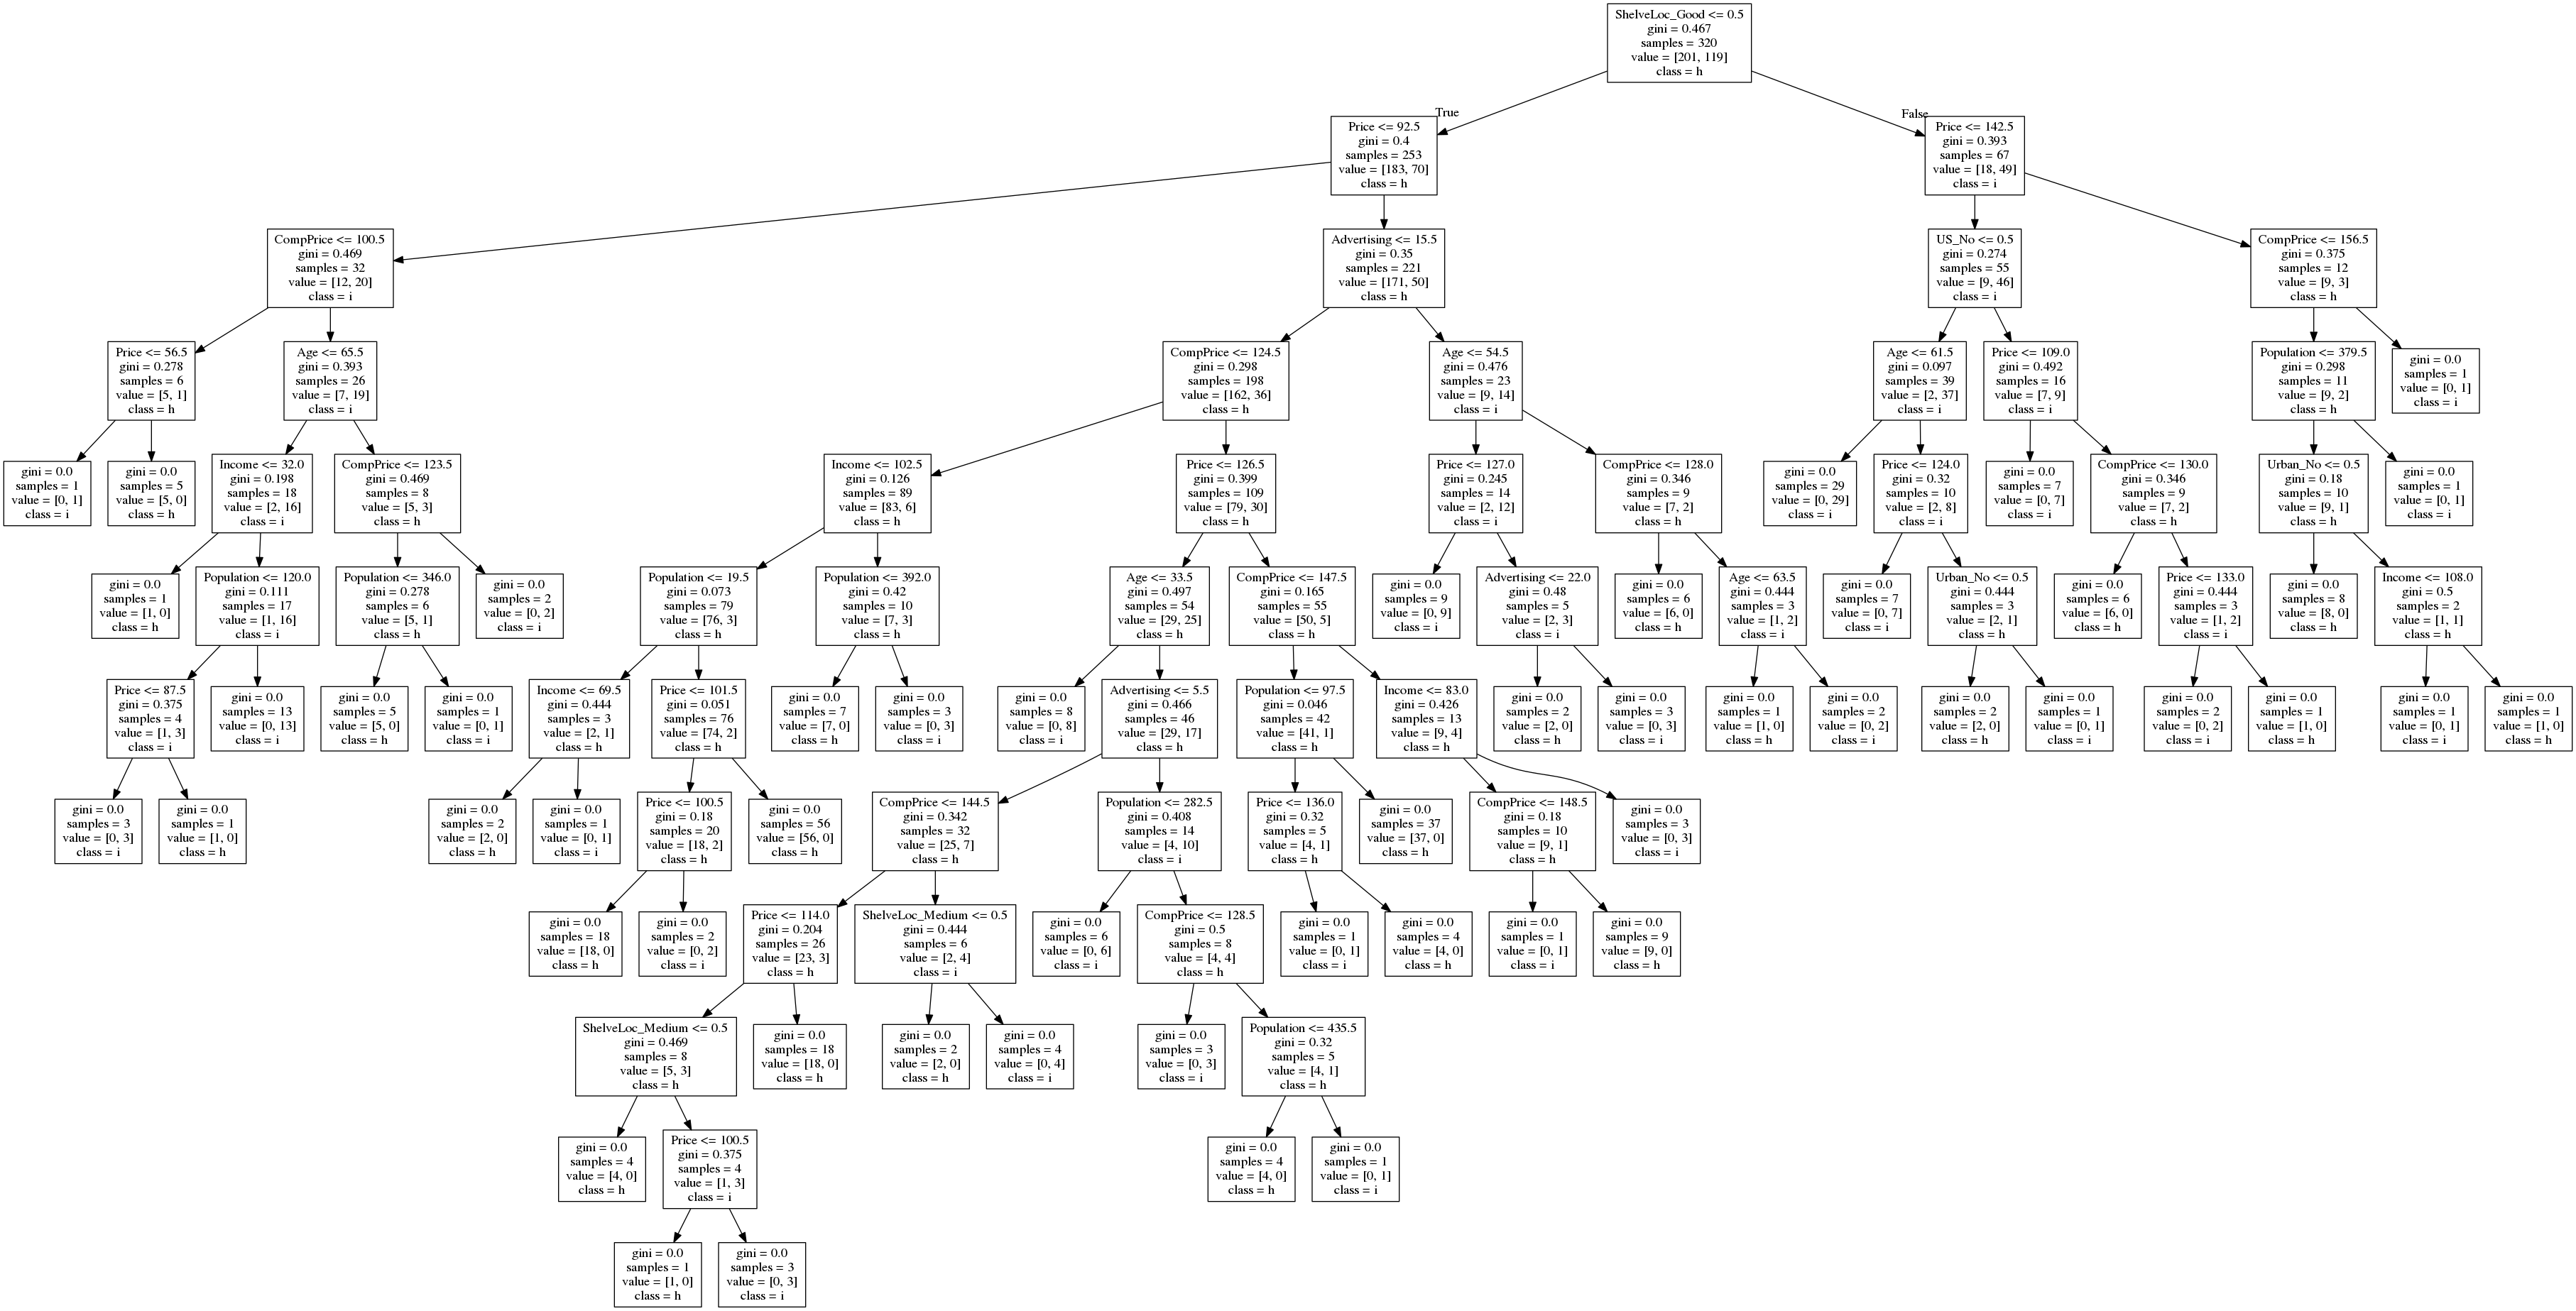

In [0]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y_clas, test_size=0.2)


dtc         = DecisionTreeClassifier(min_impurity_split = 0)
dtc_trimmed = DecisionTreeClassifier(min_impurity_split = 10e-3)

dtc        .fit(X_train, y_train)
dtc_trimmed.fit(X_train, y_train)

tree_plotter(dtc, X.columns, y_clas.columns, dtc_trimmed)

Turns out maximum depth is more effective in terms of pre-pruning.

## Trees in Regression

In this discussion we use _Boston_ dataset which is the data collected on housing in the area of Boston Mass. For more information on the dataset, please look it up!

In [0]:
#the data can be downloaded from "https://github.com/jcrouser/islr-python/blob/master/data/Boston.csv"
df = pd.read_csv('Boston.csv')

In [0]:
df.head(5)

Unnamed: 0     crim    zn  indus  chas    nox     rm   age     dis  rad  \
0           1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1           2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2           3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3           4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4           5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio   black  lstat  medv  
0  296     15.3  396.90   4.98  24.0  
1  242     17.8  396.90   9.14  21.6  
2  242     17.8  392.83   4.03  34.7  
3  222     18.7  394.63   2.94  33.4  
4  222     18.7  396.90   5.33  36.2

In [0]:
X = df.drop (labels=['Unnamed: 0', 'medv'], axis=1, inplace=False)
y = df[['medv']]

Let's train a decision tree regressor and plot it::

In [0]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(criterion = "mse")

dtr.fit(X, y)

tree_plotter(dtr, X.columns, y.columns)

The cross-validated results for regression are:

In [0]:
n_folds = 10
args    = {"criterion":["mse"]}

cross_validate_args ("dt_regressor", X, y, n_folds, args)

{'model___n_folds_10__criterion_mse': 22.54551058823529}

Now we see if pre-pruning using maximum depth is helpful:

In [0]:
n_folds = 10
args    = {"criterion":["mse"],\
           "max_depth":[1, 3, 5, 7, 9, 11]}

cross_validate_args ("dt_regressor", X, y, n_folds, args)

{'model___n_folds_10__criterion_mse__max_depth_1': 54.36120172261111,
 'model___n_folds_10__criterion_mse__max_depth_11': 15.120060649246149,
 'model___n_folds_10__criterion_mse__max_depth_3': 22.57777202463569,
 'model___n_folds_10__criterion_mse__max_depth_5': 18.57446045105084,
 'model___n_folds_10__criterion_mse__max_depth_7': 18.504648359604296,
 'model___n_folds_10__criterion_mse__max_depth_9': 20.144397687915447}

We see improvement even with maximum depth of 5.

now we define a function to plot multiple regressors:

In [0]:
import matplotlib.pyplot as plt

def regressor_plot (X_test, y_test, regressors_legends):
    plt.figure()
    for regressor_legend in regressors_legends:
        regressor = regressor_legend["regressor"]
        legend    = regressor_legend["legend"]
        
        plt.scatter(regressor.predict(X_test), y_test,\
                    label = legend)

    plt.xlabel("predicted value")
    plt.ylabel("target value")
    plt.title("target vs predicted")
    plt.legend()
    plt.show()

we now plot the results from trees with different maximum depths:

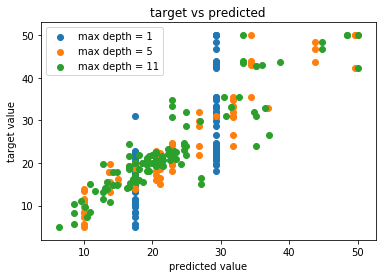

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


regressor_legend = []
for max_depth in [1,5,11]:
    
    dtr = DecisionTreeRegressor(max_depth = max_depth)
    dtr.fit(X_train, y_train.values.ravel())
    regressor_legend.append({"regressor":dtr,\
                             "legend"   :"max depth = %s"%max_depth})

regressor_plot (X_test, y_test, regressor_legend)

## Baggining and Random Forests

Now let's see how random forest regressor performs on this data:

In [0]:
n_folds = 10
args    = {"criterion"    : ["mse"],\
           "n_estimators" : [1,20,40]}

cross_validate_args ("rf_regressor", X, y, n_folds, args)

{'model___n_folds_10__criterion_mse__n_estimators_1': 26.604383529411766,
 'model___n_folds_10__criterion_mse__n_estimators_20': 12.515573437254904,
 'model___n_folds_10__criterion_mse__n_estimators_40': 10.92715150416667}

This is significantly lower than that of a single decision tree.

Let's see the target vs predicted plots:

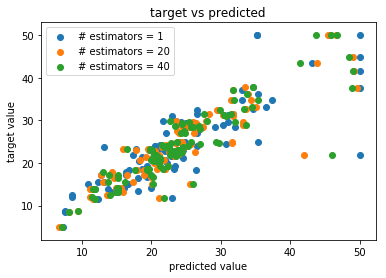

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor_legend = []
for n_estimators in [1,20,40]:
    
    rfr = RandomForestRegressor(n_estimators = n_estimators)
    rfr.fit(X_train, y_train.values.ravel())
    regressor_legend.append({"regressor":rfr,\
                             "legend"   :"# estimators = %s"%n_estimators})

regressor_plot (X_test, y_test, regressor_legend)

In the case of number of estimators equal to 20, we can compute the feature importances by:

In [0]:
rfr = RandomForestRegressor(n_estimators = 20)
rfr.fit(X, y.values.ravel())

feature_importances = dict(zip(X.columns, rfr.feature_importances_))
print (feature_importances)

{'rm': 0.49825610423099037, 'tax': 0.013033884625890144, 'nox': 0.01987439825696828, 'zn': 0.001096246037811638, 'dis': 0.06899164830793621, 'age': 0.013277874592226745, 'crim': 0.03199068240343365, 'rad': 0.0024062152666844395, 'black': 0.01325595285479183, 'chas': 0.0005390399305665333, 'ptratio': 0.015267908672970981, 'indus': 0.004026372777309424, 'lstat': 0.31798367204241973}


If now we grid searh on different parameters of random forest, namely, number of trees and max depth, we have:

In [0]:
n_folds = 10
args    = {"max_depth"    : [1,5,11],\
           "n_estimators" : [1,20,40,60,80,100,200,300]}

cross_validate_args ("rf_regressor", X, y, n_folds, args)

{'model___n_folds_10__max_depth_11__n_estimators_1': 24.311254444950162,
 'model___n_folds_10__max_depth_11__n_estimators_100': 10.562421308916559,
 'model___n_folds_10__max_depth_11__n_estimators_20': 11.74875069574198,
 'model___n_folds_10__max_depth_11__n_estimators_200': 10.304492082946739,
 'model___n_folds_10__max_depth_11__n_estimators_300': 10.143706695423308,
 'model___n_folds_10__max_depth_11__n_estimators_40': 11.010303720963112,
 'model___n_folds_10__max_depth_11__n_estimators_60': 10.438843967478121,
 'model___n_folds_10__max_depth_11__n_estimators_80': 10.572010478189886,
 'model___n_folds_10__max_depth_1__n_estimators_1': 55.50971304541603,
 'model___n_folds_10__max_depth_1__n_estimators_100': 37.21387323593269,
 'model___n_folds_10__max_depth_1__n_estimators_20': 39.492047130205094,
 'model___n_folds_10__max_depth_1__n_estimators_200': 39.05622160990948,
 'model___n_folds_10__max_depth_1__n_estimators_300': 36.89420074444065,
 'model___n_folds_10__max_depth_1__n_estimat

As can be seen, random forest is very robust against overfitting.